In [1]:
%matplotlib notebook
import logging
import os
import math
import multiprocessing
import json
import re
from itertools import combinations
    
from scipy.stats import t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc("font", size=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("legend", fontsize=14)
plt.rc("figure", titlesize=14)

In [4]:
MCS6 = "/hdd/results-analysis/data/parsed_data/andres-mcs/mcs6-2021-05-07-10_00_30"
MCS11 = "/hdd/results-analysis/data/parsed_data/andres-mcs/mcs11-2021-05-07-10_00_41"
Adaptive = "/hdd/results-analysis/data/parsed_data/andres-mcs/adaptive-2021-05-07-09_59_55"

In [5]:
configs = {
    "MCS 6": MCS6,  
    "MCS 11": MCS11,
    "Adaptive": Adaptive
}

In [8]:
results_rriChange = {}
results_missedTrans = {}
results_knownCollision = {}
results_timing = {}
results_total = {}

for config in configs:
    print("="*60)
    print("Dealing with config: {}".format(config))
    
    if configs[config] == "":
        continue
    
    results_rriChange[config] = []
    results_missedTrans[config] = []
    results_knownCollision[config] = []
    results_timing[config] = []
    results_total[config] = []
    
    for run in range(1,6):
            
        print("Dealing with run: {}".format(run))
        
        grant_info = pd.DataFrame()
        missed_trans = pd.DataFrame()
        rriChange_info = pd.DataFrame()
        hd_errors = pd.DataFrame()
        send_info = pd.DataFrame()
        received_info = pd.DataFrame()

        for chunk in pd.read_csv("{}/run-{}.csv".format(configs[config], run), chunksize=10 ** 6):
            
            chunk = chunk[
                [
                    "NodeID", "Time", "missedTransmission", "grantStartTime", "retainGrant", 
                    "resourceReselectionCounter", "selectedSubchannelIndex", 
                    "subchannelSent", "tbSent", "tbDecoded",  "subchannelReceived", "tbFailedHalfDuplex",
                    "senderID", "txRxDistanceTB", "txRxDistanceSCI"
                ]
            ]

            # Get the grant info
            grant_chunk = chunk[["NodeID", "Time", "grantStartTime", "retainGrant",
                                 "resourceReselectionCounter", "selectedSubchannelIndex"]]
            grant_chunk = grant_chunk.dropna(thresh=4)

            # Get the missed transmissions
            missed_chunk = chunk[["NodeID", "Time", "missedTransmission"]]

            missed_chunk = missed_chunk[missed_chunk["missedTransmission"] == 1]

            # Get HD errors
            hd_chunk = chunk[["NodeID", "Time", "senderID", "subchannelReceived",
                              "tbFailedHalfDuplex", "txRxDistanceTB", "txRxDistanceSCI"]]

            hd_chunk = hd_chunk[hd_chunk["tbFailedHalfDuplex"] == 1]

            # Get sent info
            send_chunk = chunk[["NodeID", "Time", "tbSent", "subchannelSent"]]

            send_chunk = send_chunk[send_chunk["tbSent"] == 1]

            received_chunk = chunk[["NodeID", "Time", "tbDecoded", "subchannelReceived", "senderID",
                                   "tbFailedHalfDuplex", "txRxDistanceTB", "txRxDistanceSCI"]]

            received_chunk = received_chunk[received_chunk["txRxDistanceSCI"] > 0]

            # Combine into overall folder
            if grant_info.empty:
                grant_info = grant_chunk
            else:
                grant_info = grant_info.append(grant_chunk, ignore_index=True)

            if missed_trans.empty:
                missed_trans = missed_chunk
            else:
                missed_trans = missed_trans.append(missed_chunk, ignore_index=True)

            if hd_errors.empty:
                hd_errors = hd_chunk
            else:
                hd_errors = hd_errors.append(hd_chunk, ignore_index=True)

            if send_info.empty:
                send_info = send_chunk
            else:
                send_info = send_info.append(send_chunk, ignore_index=True)

            if received_info.empty:
                received_info = received_chunk
            else:
                received_info = received_info.append(received_chunk, ignore_index=True)
                
        ## Deal with full file

        grant_info["grantEndTime"] = grant_info["grantStartTime"] + 0.1 * grant_info["resourceReselectionCounter"]

        first_transmission = pd.merge(grant_info, send_info, left_on=["NodeID"], right_on=["NodeID"])

        first_transmission = first_transmission[(first_transmission["Time_y"] 
                                                 >= first_transmission["grantStartTime"]) &
                                                (first_transmission["Time_y"] 
                                                 <= first_transmission["grantEndTime"])]

        first_transmission = first_transmission.drop_duplicates(subset=["NodeID","Time_x",
                                                                        "grantStartTime","retainGrant",
                                                                        "resourceReselectionCounter",
                                                                        "selectedSubchannelIndex",
                                                                        "grantEndTime"],
                                                                keep="first")

        first_transmission = first_transmission.rename(columns={"Time_y": "TransmissionTime",
                                                                "subchannelSent": "Subchannel"})

        first_transmission = first_transmission[["NodeID", "grantStartTime", "grantEndTime", 
                                                 "TransmissionTime", "Subchannel"]]

        first_after_missed = pd.merge(missed_trans, send_info, on=["NodeID"])

        first_after_missed = first_after_missed[first_after_missed["Time_x"] == 
                                                (first_after_missed["Time_y"] - 0.1)]

        first_after_missed = first_after_missed.rename(columns={"Time_x": "missedTime", 
                                                                "Time_y": "TransmissionTime",
                                                                "subchannelSent": "Subchannel"})

        first_after_missed = first_after_missed[["NodeID", "missedTime",
                                                 "TransmissionTime", "Subchannel"]]

        ### Updated 

        colliding_transmission = pd.merge(first_transmission, first_after_missed,
                                          left_on=["TransmissionTime", "Subchannel"],
                                          right_on = ["TransmissionTime", "Subchannel"])

        colliding_transmission = colliding_transmission[colliding_transmission["NodeID_x"] != 
                                                        colliding_transmission["NodeID_y"]]

        colliding_transmission = colliding_transmission.drop_duplicates(
            subset=["TransmissionTime", "Subchannel", "missedTime"])

        colliding_transmission = colliding_transmission[
            ["NodeID_x", "NodeID_y", "Subchannel", "TransmissionTime"]]

        colliding_transmission["HD_Time"] = colliding_transmission["TransmissionTime"] + 0.001

        hd_errors["senderID"] = hd_errors["senderID"].apply(lambda x: x-1025).astype(int)

        all_info = pd.merge(colliding_transmission, hd_errors, 
                               left_on=["NodeID_x", "NodeID_y", "HD_Time", "Subchannel"],
                               right_on=["NodeID", "senderID", "Time", "subchannelReceived"])

        all_info = all_info[["NodeID_x", "NodeID_y", "Time", "Subchannel", "txRxDistanceSCI"]]

        colliding_grants = pd.merge(grant_info, grant_info, on=["grantStartTime", "selectedSubchannelIndex"])
        colliding_grants = colliding_grants[colliding_grants["NodeID_x"] != colliding_grants["NodeID_y"]]
        grant_hds = pd.merge(colliding_grants, hd_errors, left_on=["NodeID_x", "NodeID_y"],
                                   right_on=["NodeID", "senderID"])
        grant_hds = grant_hds.drop_duplicates(subset=["NodeID_x", "NodeID_y", "NodeID", "senderID"])
        grant_hds = grant_hds.drop_duplicates(subset=["txRxDistanceTB"])

        missed_trans_colls = len(all_info[all_info["txRxDistanceSCI"] < 500])
        timing_colls = len(grant_hds[grant_hds["txRxDistanceSCI"] < 500])

        total_colls = missed_trans_colls + known_colls + timing_colls

        results_missedTrans[config].append(missed_trans_colls)
        results_knownCollision[config].append(known_colls)
        results_timing[config].append(timing_colls)

        results_rriChange[config].append(0)

        results_total[config].append(total_colls)
            
    
    print("HD Errors {}".format(hd_errors[hd_errors["txRxDistanceTB"] < 500]["NodeID"].count()))
    print("Messages received {}".format(received_info[received_info["txRxDistanceTB"] < 500]["NodeID"].count()))
    print("Messages sent {}".format(send_info["NodeID"].count()))

Dealing with config: MCS 6
Dealing with run: 1


ValueError: Cannot convert non-finite values (NA or inf) to integer

In [9]:
hd_errors

,NodeID,Time,senderID,subchannelReceived,tbFailedHalfDuplex,txRxDistanceTB,txRxDistanceSCI
0,81,500.021,NaN,0.0,1.0,56.011863,56.011863
1,129,500.022,NaN,0.0,1.0,486.382354,486.382354
2,97,500.068,NaN,0.0,1.0,127.206776,127.206776
3,55,500.076,NaN,0.0,1.0,552.163419,552.163419
4,22,500.103,NaN,0.0,1.0,1067.724104,1067.724104
...,...,...,...,...,...,...,...
35647,194,507.000,NaN,0.0,1.0,403.302248,403.302248
35648,194,507.000,NaN,0.0,1.0,717.063370,717.063370
35649,223,507.000,NaN,0.0,1.0,29.731962,29.731962
35650,223,507.000,NaN,0.0,1.0,268.737546,268.737546


In [5]:
result_type = [results_rriChange, results_missedTrans, results_knownCollision, results_timing, results_total]
for res in result_type:
    config = []
    for key in res:
        config.append(key)
        res[key] = sum(res[key]) / len(res[key])

In [18]:
results_rriChange = {}

results_rriChange["RRI CRlimit 20%"] = 0.0
results_rriChange["RRI CRlimit 60%"] = 1.8

results_rriChange["DCC Adaptive 20%"] = 0.0
results_rriChange["DCC Adaptive 60%"] = 0.0
    
results_rriChange["RRI Lookup"] = 0.2

results_rriChange["DCC Reactive"] = 0.0
    
results_rriChange["Packet Dropping (aggressive)"] = 0.0

results_rriChange["congested"] = 0.0

In [19]:
results_missedTrans = {}

results_missedTrans["RRI CRlimit 20%"] = 0.0
results_missedTrans["RRI CRlimit 60%"] = 0.0

results_missedTrans["DCC Adaptive 20%"] = 677.8
results_missedTrans["DCC Adaptive 60%"] = 848.6
    
results_missedTrans["RRI Lookup"] = 0.0

results_missedTrans["DCC Reactive"] = 338.4
    
results_missedTrans["Packet Dropping (aggressive)"] = 888.6

results_missedTrans["congested"] = 0.0

In [20]:
results_knownCollision = {}

results_knownCollision["RRI CRlimit 20%"] = 0.0
results_knownCollision["RRI CRlimit 60%"] = 556.0

results_knownCollision["DCC Adaptive 20%"] = 0.0
results_knownCollision["DCC Adaptive 60%"] = 2581.6
    
results_knownCollision["RRI Lookup"] = 258.0

results_knownCollision["DCC Reactive"] = 399.2
    
results_knownCollision["Packet Dropping (aggressive)"] = 0

results_knownCollision["congested"] = 3623.0

In [21]:
results_timing = {}

results_timing["RRI CRlimit 20%"] = 62.0
results_timing["RRI CRlimit 60%"] = 210.2

results_timing["DCC Adaptive 20%"] = 1608.0
results_timing["DCC Adaptive 60%"] = 1484.8
    
results_timing["RRI Lookup"] = 169.2

results_timing["DCC Reactive"] = 4147.4
    
results_timing["Packet Dropping (aggressive)"] = 676.0

results_timing["congested"] = 1431.6

In [22]:
results_total = {}

results_total["RRI CRlimit 20%"] = 62.0
results_total["RRI CRlimit 60%"] = 768.0

results_total["DCC Adaptive 20%"] = 2285.8
results_total["DCC Adaptive 60%"] = 4915.0
    
results_total["RRI Lookup"] = 427.4

results_total["DCC Reactive"] = 4885.0
    
results_total["Packet Dropping (aggressive)"] = 1564.6

results_total["congested"] = 5054.6

In [29]:
for config in results_total:
    print("="*80)
    print("Config              : {} ".format(config))
    print("RRI Change          : {}% ".format((results_rriChange[config] / results_total[config] * 100)))
    print("Missed Transmission : {}%".format((results_missedTrans[config] / results_total[config] * 100)))
    print("Known               : {}%".format((results_knownCollision[config] / results_total[config] * 100)))
    print("Timing              : {}%".format((results_timing[config] / results_total[config] * 100)))
    print("Total               : {}".format(results_total[config]))

Config              : RRI CRlimit 20% 
RRI Change          : 0.0% 
Missed Transmission : 0.0%
Known               : 0.0%
Timing              : 100.0%
Total               : 62.0
Config              : RRI CRlimit 60% 
RRI Change          : 0.234375% 
Missed Transmission : 0.0%
Known               : 72.39583333333334%
Timing              : 27.369791666666664%
Total               : 768.0
Config              : DCC Adaptive 20% 
RRI Change          : 0.0% 
Missed Transmission : 29.65263802607402%
Known               : 0.0%
Timing              : 70.34736197392597%
Total               : 2285.8
Config              : DCC Adaptive 60% 
RRI Change          : 0.0% 
Missed Transmission : 17.265513733468975%
Known               : 52.524923702950154%
Timing              : 30.20956256358087%
Total               : 4915.0
Config              : RRI Lookup 
RRI Change          : 0.04679457182966776% 
Missed Transmission : 0.0%
Known               : 60.36499766027141%
Timing              : 39.58820776789892

<IPython.core.display.Javascript object>


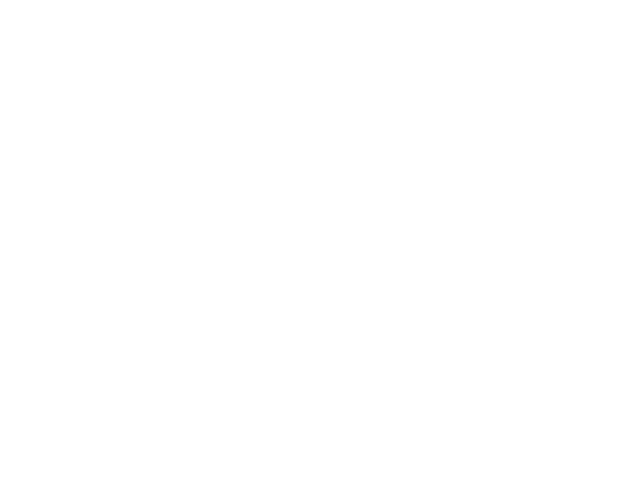

In [23]:
fig, ax = plt.subplots()

width = 0.3  # the width of the bars

labels = ["DCC\nReactive", "DCC\nAdaptive", "Packet\nDropping\n(Aggressive)", "$RRI_{CR\_limit}$", "$RRI_{Lookup}$"]

rects1 = ax.bar(0, results_total["DCC Reactive"], width, capsize=10, 
                color='none', fill=False, edgecolor='red', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(1, results_total["DCC Adaptive 20%"], width, capsize=10,
                color='none', fill=False, edgecolor='blue', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(2, results_total["Packet Dropping (aggressive)"], width, capsize=10,
                color='none', fill=False, edgecolor='green', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(3, results_total["RRI CRlimit 20%"], width, capsize=10,
                color='none', fill=False, edgecolor='darkorange', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(4, results_total["RRI Lookup"], width, capsize=10,
                color='none', fill=False, edgecolor='cyan', hatch='//', lw=1., zorder = 0, alpha=1)

ax.set_ylabel('Average colliding grants')
ax.set_ylim(0, 5000)
plt.yticks(np.arange(0, 5001, 500))
plt.xticks([r for r in range(len(labels))], labels)
ax.set_xticklabels(labels)

fig.tight_layout()
plt.savefig("../data/figures/Congestion-Control-20pc-Colliding-Grants.eps")
plt.close()

<IPython.core.display.Javascript object>


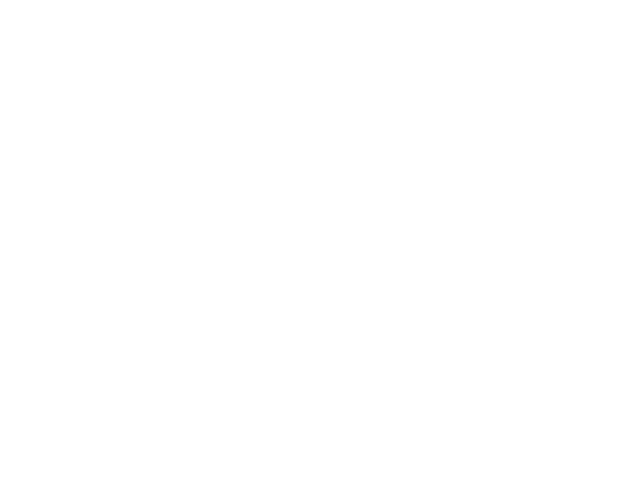

In [24]:
fig, ax = plt.subplots()

width = 0.3  # the width of the bars

labels = ["DCC\nAdaptive","$RRI_{CR\_limit}$"]

rects1 = ax.bar(0, results_total["DCC Adaptive 60%"], width, capsize=10,
                color='none', fill=False, edgecolor='red', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(1, results_total["RRI CRlimit 60%"], width, capsize=10,
                color='none', fill=False, edgecolor='blue', hatch='//', lw=1., zorder = 0, alpha=1)

ax.set_ylabel('Average colliding grants')
ax.set_ylim(0, 5000)
plt.yticks(np.arange(0, 5001, 500))
plt.xticks([r for r in range(len(labels))], labels)
ax.set_xticklabels(labels)

fig.tight_layout()
plt.savefig("../data/figures/Congestion-Control-60pc-Colliding-Grants.eps")
plt.close()

<IPython.core.display.Javascript object>


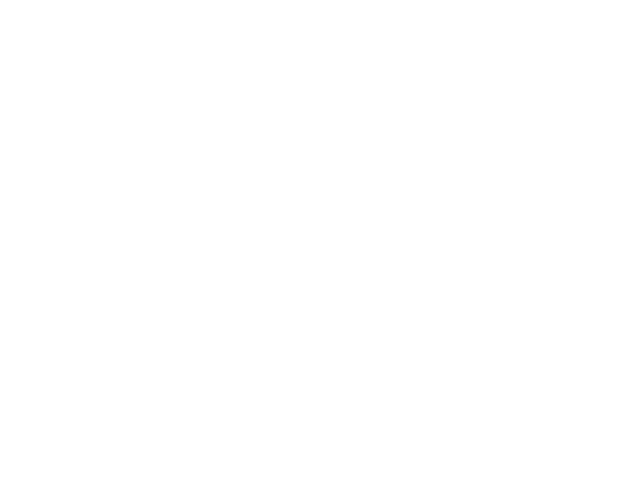

In [25]:
fig, ax = plt.subplots()

width = 0.75  # the width of the bars

labels = [
    "DCC\nTotal",
    "DCC\nMiss",
    "DCC\nKnown",
    "DCC\nTime",
    "$RRI_{CR}$\nTotal",
    "$RRI_{CR}$\nRRI-C",
    "$RRI_{CR}$\nKnown",
    "$RRI_{CR}$\nTime"
]

# Total
rects1 = ax.bar(0, results_total["DCC Adaptive 60%"], width, capsize=10,
                color='none', fill=False, edgecolor='red', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(4, results_total["RRI CRlimit 60%"], width, capsize=10,
                color='none', fill=False, edgecolor='red', hatch='//', lw=1., zorder = 0, alpha=1)

# RRI/Missed
rects1 = ax.bar(1, results_missedTrans["DCC Adaptive 60%"], width, capsize=10,
                color='none', fill=False, edgecolor='blue', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(5, results_rriChange["RRI CRlimit 60%"], width, capsize=10,
                color='none', fill=False, edgecolor='blue', hatch='//', lw=1., zorder = 0, alpha=1)

# Known Collisions
rects1 = ax.bar(2, results_knownCollision["DCC Adaptive 60%"], width, capsize=10,
                color='none', fill=False, edgecolor='green', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(6, results_knownCollision["RRI CRlimit 60%"], width, capsize=10,
                color='none', fill=False, edgecolor='green', hatch='//', lw=1., zorder = 0, alpha=1)

# Same timing
rects1 = ax.bar(3, results_timing["DCC Adaptive 60%"], width, capsize=10,
                color='none', fill=False, edgecolor='purple', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(7, results_timing["RRI CRlimit 60%"], width, capsize=10,
                color='none', fill=False, edgecolor='purple', hatch='//', lw=1., zorder = 0, alpha=1)

ax.set_ylabel('Average colliding grants')
ax.set_ylim(0, 5000)
plt.yticks(np.arange(0, 5001, 500))
plt.xticks([r for r in range(len(labels))], labels)
ax.set_xticklabels(labels)

fig.tight_layout()
# plt.show()
plt.savefig("../data/figures/Congestion-Control-60pc-Colliding-Grants-breakdown.eps")
plt.close()

<IPython.core.display.Javascript object>


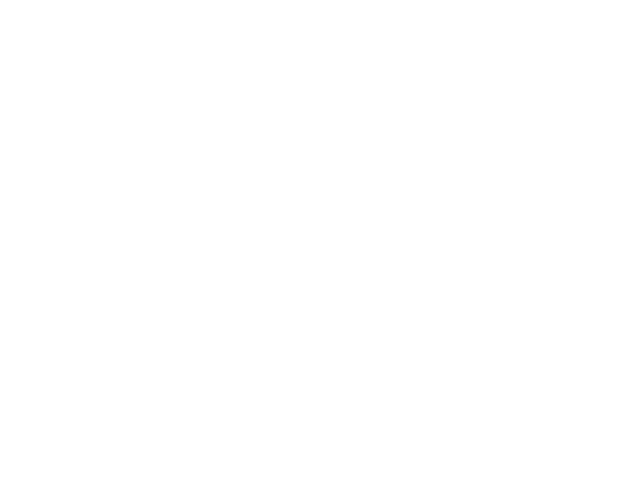

In [62]:
fig, ax = plt.subplots()

width = 0.75  # the width of the bars

labels = [
    "DCC\nTotal",
    "DCC\nMiss",
    "DCC\nKnown",
    "DCC\nTime",
    "$RRI_{CR}$\nTotal",
    "$RRI_{CR}$\nRRI-C",
    "$RRI_{CR}$\nKnown",
    "$RRI_{CR}$\nTime"
]

# Total
rects1 = ax.bar(0, results_total["DCC Adaptive 20%"], width, capsize=10,
                color='none', fill=False, edgecolor='red', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(4, results_total["RRI CRlimit 20%"], width, capsize=10,
                color='none', fill=False, edgecolor='red', hatch='//', lw=1., zorder = 0, alpha=1)

# RRI/Missed
rects1 = ax.bar(1, results_missedTrans["DCC Adaptive 20%"], width, capsize=10,
                color='none', fill=False, edgecolor='blue', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(5, results_rriChange["RRI CRlimit 20%"], width, capsize=10,
                color='none', fill=False, edgecolor='blue', hatch='//', lw=1., zorder = 0, alpha=1)

# Known Collisions
rects1 = ax.bar(2, results_knownCollision["DCC Adaptive 20%"], width, capsize=10,
                color='none', fill=False, edgecolor='green', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(6, results_knownCollision["RRI CRlimit 20%"], width, capsize=10,
                color='none', fill=False, edgecolor='green', hatch='//', lw=1., zorder = 0, alpha=1)

# Same timing
rects1 = ax.bar(3, results_timing["DCC Adaptive 20%"], width, capsize=10,
                color='none', fill=False, edgecolor='purple', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(7, results_timing["RRI CRlimit 20%"], width, capsize=10,
                color='none', fill=False, edgecolor='purple', hatch='//', lw=1., zorder = 0, alpha=1)

ax.set_ylabel('Average colliding grants')
ax.set_ylim(0, 5000)
plt.yticks(np.arange(0, 5001, 500))
plt.xticks([r for r in range(len(labels))], labels)
ax.set_xticklabels(labels)

fig.tight_layout()
# plt.show()
plt.savefig("../data/figures/Congestion-Control-20pc-Colliding-Grants-breakdown.eps")
plt.close()

<IPython.core.display.Javascript object>


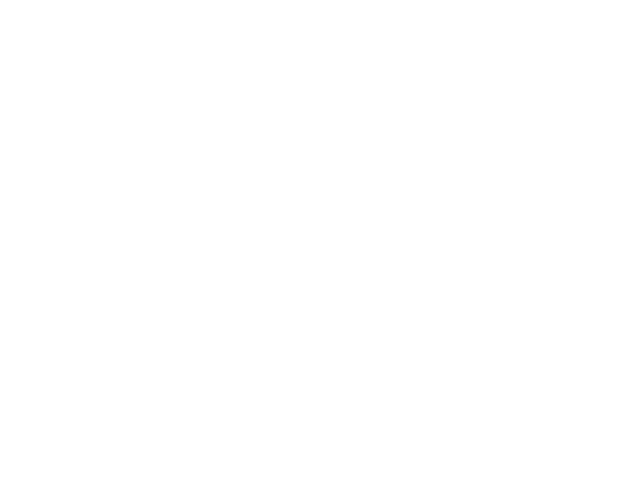

In [133]:
fig, ax = plt.subplots()

width = 0.3  # the width of the bars

labels = ["DCC\nAdaptive","$RRI_{CR\_limit}$"]

rects1 = ax.bar(0, results["DCC Adaptive 40%"], width, capsize=10, color='none', fill=False, edgecolor='red', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(1, results["RRI_CRlimit 40%"], width, capsize=10, color='none', fill=False, edgecolor='blue', hatch='//', lw=1., zorder = 0, alpha=1)

ax.set_ylabel('Average colliding grants')
ax.set_ylim(0, 1900)
plt.yticks(np.arange(0, 1901, 200))
plt.xticks([r for r in range(len(labels))], labels)
ax.set_xticklabels(labels)

fig.tight_layout()
plt.savefig("../data/figures/Congestion-Control-40pc-Colliding-Grants.eps")
plt.close()

<IPython.core.display.Javascript object>


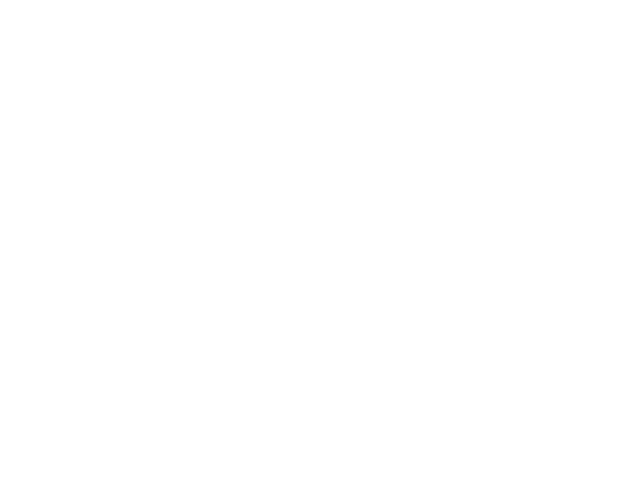

In [134]:
fig, ax = plt.subplots()

width = 0.3  # the width of the bars

labels = ["Packet Dropping\n(3GPP)","Packet Dropping\n(ETSI)","Packet Dropping\n(Aggressive)"]

rects1 = ax.bar(0, results["Packet Dropping (3GPP)"], width, capsize=10, color='none', fill=False, edgecolor='red', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(1, results["Packet Dropping (ETSI)"], width, capsize=10, color='none', fill=False, edgecolor='blue', hatch='//', lw=1., zorder = 0, alpha=1)
rects1 = ax.bar(1, results["Packet Dropping (aggressive)"], width, capsize=10, color='none', fill=False, edgecolor='green', hatch='//', lw=1., zorder = 0, alpha=1)

ax.set_ylabel('Average colliding grants')
ax.set_ylim(0, 1900)
plt.yticks(np.arange(0, 1901, 200))
plt.xticks([r for r in range(len(labels))], labels)
ax.set_xticklabels(labels)

fig.tight_layout()
plt.savefig("../data/figures/Pdrop-variants-Colliding-Grants.eps")
plt.close()